<a href="https://colab.research.google.com/github/krmonline/AnomalyDetection/blob/master/LSTM_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import tensorflow.keras as keras
#from keras.models import Sequential, Model
#from keras.layers import LSTM  ,RepeatVector ,TimeDistributed , Dense ,  GRU
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [44]:
df = pd.read_csv('https://raw.githubusercontent.com/krmonline/AnomalyDetection/master/data/timeseries1.csv',names=['eps'])
len(df.eps)
series = df.eps.values

In [45]:
from sklearn.preprocessing import minmax_scale

In [46]:
#Prepare
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        #print("end_ix="+str(end_ix))
        if end_ix > len(sequence)-1:
            break
        seq_x = [tmp for tmp in sequence[i:end_ix]]
        X.append(seq_x)
    return np.array(X)

seq_step  = 5

In [4]:
series

array([ 7009.73,  5900.36,  5076.96,  4375.26,  3925.37,  3612.11,
        3402.24,  3168.53,  3070.1 ,  3002.69,  3230.84,  3733.5 ,
        4857.46,  5934.53,  6778.85,  7120.24,  7250.54,  7830.7 ,
        8276.09,  8556.56,  9035.95,  9075.68,  9249.67,  9505.02,
       10071.73, 10770.5 ,  9751.96,  9202.01,  9199.  ,  9369.79,
        9605.51,  9457.09,  9740.06, 10089.13, 10466.14, 10565.14,
       10910.92, 11112.14, 11717.95, 12716.7 , 13764.65, 14076.19,
       14092.43, 13500.16, 12467.85, 10993.16,  9632.4 ,  8050.71,
        6882.02,  5774.72,  4905.43,  4363.57,  3950.9 ,  3624.78,
        3489.09,  3264.79,  3094.17,  3098.02,  3294.04,  3797.86,
        4843.88,  5945.92,  6771.27,  7076.01,  7037.24,  7525.28,
        7975.74,  8334.62,  8725.08,  8683.95,  8853.67,  9110.68,
        9548.82, 10158.85,  9306.97,  8889.26,  8837.89,  8934.68,
        9226.07,  9179.46,  9551.27,  9899.16, 10368.25, 10543.45,
       11113.51, 11410.15, 11945.87, 12849.52, 13901.7 , 14493

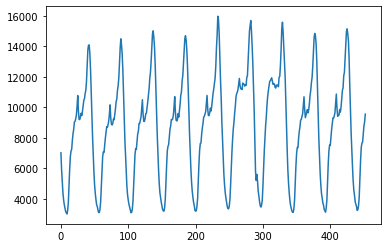

In [5]:
plt.plot(df)

In [6]:
series_scale = minmax_scale(df.eps.values)

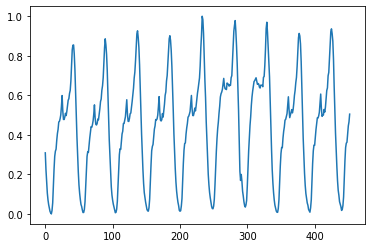

In [7]:
plt.plot(series_scale)

In [10]:
train_set = split_sequence(series_scale,seq_step)
display(train_set)
train_set.shape

array([[0.30888917, 0.22337158, 0.15989846, 0.10580678, 0.07112628],
       [0.22337158, 0.15989846, 0.10580678, 0.07112628, 0.04697813],
       [0.15989846, 0.10580678, 0.07112628, 0.04697813, 0.03079996],
       ...,
       [0.26946399, 0.3355303 , 0.35786307, 0.36261931, 0.40318306],
       [0.3355303 , 0.35786307, 0.36261931, 0.40318306, 0.44503878],
       [0.35786307, 0.36261931, 0.40318306, 0.44503878, 0.46533183]])

(448, 5)

In [15]:
sequence = train_set.reshape(train_set.shape[0],seq_step,-1)
sequence.shape

(448, 5, 1)

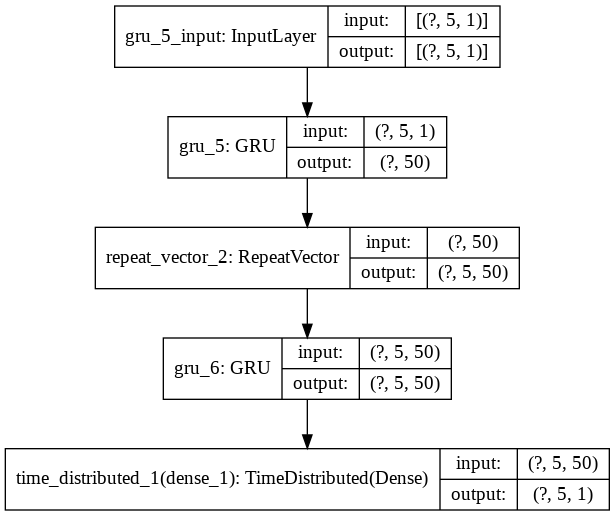

In [24]:
# define model
history=[]
model = keras.Sequential()
model.add(keras.layers.GRU(50, activation='relu', input_shape=(seq_step,1)))
model.add(keras.layers.RepeatVector(seq_step))
model.add(keras.layers.GRU(50, activation='relu', return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 50)                7950      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 50)             0         
_________________________________________________________________
gru_6 (GRU)                  (None, 5, 50)             15300     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              51        
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_tmp=model.fit(sequence, sequence, epochs=1000, verbose=1)
history.extend(history_tmp.history['loss'])

Epoch 1/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.2232
Epoch 2/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.1211
Epoch 3/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0506
Epoch 4/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0264
Epoch 5/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 6/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 7/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 8/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 9/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 10/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 11/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 12/1000
14/14 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 13/1000
14/14 [====

#Train ที่ 100 epochs ได้ค่า MSE อยู่ที่ ~ 10

6.450618820963427e-05


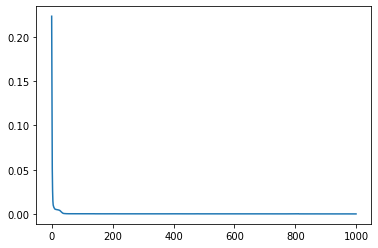

In [27]:
plt.plot(history)
print(history[-1])

In [ ]:
model.save("lstm_autoencoder.f5")
model.save_weights("lstm_autoencoder_weight.f5")

In [ ]:
model.load_weights('lstm_autoencoder_weight.f5')

In [32]:
test = sequence[125].copy()
test = test.reshape(1,5,1)
print(test.shape)
print(test)

(1, 5, 1)
[[[0.48288292]
  [0.50658243]
  [0.51027488]
  [0.53789424]
  [0.5688291 ]]]


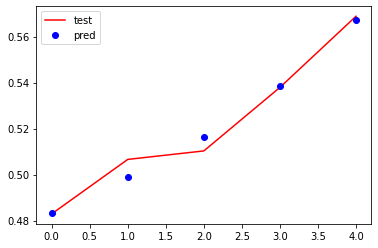

In [33]:
pred = model.predict([test])
pred2 = pred.reshape(5,1)

plt.plot(test.reshape(5,1),'r-')

plt.plot(pred2.reshape(5,1),'bo')
plt.legend(['test','pred'])

# เมื่อนำ Data Test และ Pred มาเทียบกันพบว่าใกล้เคียงกัน

In [34]:
diff = test - pred
print(abs(diff))
print(mean_squared_error(test.reshape(5,1), pred.reshape(5,1)))

[[[0.00049782]
  [0.00762157]
  [0.00595738]
  [0.00059075]
  [0.00179319]]]
1.947821055677739e-05


#แก้จุดที่ 2 ให้สูงผิดปรกติ (Anomaly)

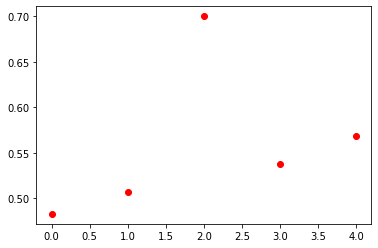

In [35]:
test[0][2][0] = 0.7
plt.plot(test.reshape(5,1),'ro')

#ผลที่ได้คือ Predict ออกมาไม่เหมือนกันกับ Data ที่นำเข้าเนื่องจากเราสร้าง anomaly ขึ้นมาเอง Model ไม่เคยเห็นมาก่อน และ MSE มีค่าสูง 

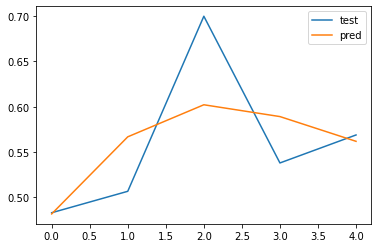

In [36]:
pred = model.predict([test])
pred = pred.reshape(5,1)
plt.plot(test.reshape(5,1))
plt.plot(pred)
plt.legend(['test','pred'])

In [37]:
diff = test - pred
print(abs(diff))
print(mean_squared_error(test.reshape(5,1), pred.reshape(5,1)))

[[[0.00129375]
  [0.06018783]
  [0.09781028]
  [0.05124671]
  [0.00702451]]]
0.003173333727743989


# TEST

#เราสร้างจุดที่เป็น Anomaly ขึ้นมา ให้เกิดความผิดปรกติขึ้นและนำ Data เข้าไปใน Model

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/krmonline/AnomalyDetection/master/data/timeseries4.csv',names=['eps'])
data1 = df['eps'].values[:]
data1 = np.asarray(data1)
#data1[180] =  20000
data1[90] = 10000
data1[10] = 12000
data1[50] = 7000
data1[150] = 7000

In [39]:
data1 = minmax_scale(data1)
test_set = split_sequence(data1,seq_step)
display(test_set[-1])
test_set.shape

array([0.35418694, 0.36108571, 0.40501596, 0.44765987, 0.47150164])

(448, 5)

In [40]:
mseval = []
for i in test_set:
    test = i.reshape(1,5,1)
    pred = model.predict([test])
    mse = mean_squared_error(test.reshape(5,1),pred.reshape(5,1))
    mseval.append(mse)

#ตั้ง Threshold ให้กับค่า MSE

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


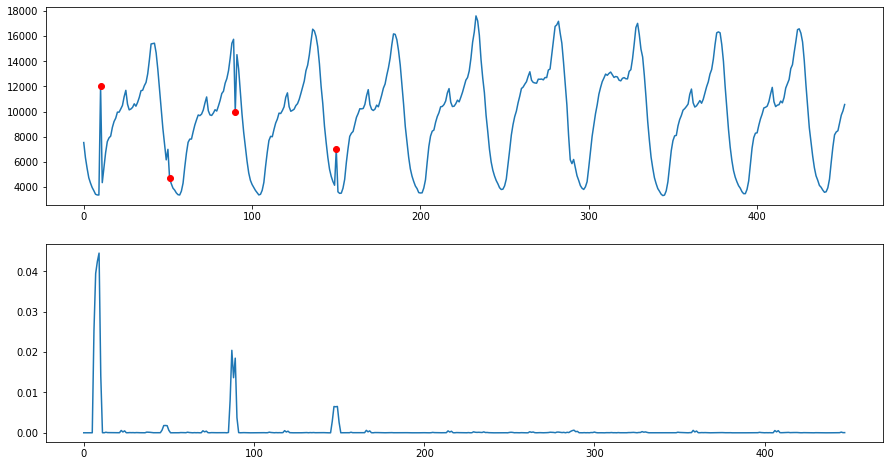

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

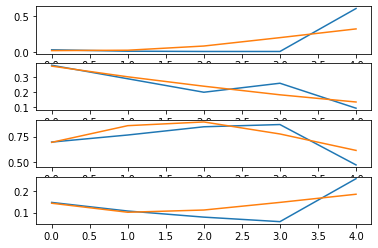

In [42]:
plt.figure(figsize=(15, 8))
anomaly = False
anomaly_pos2 = []
anomaly_pos = 0
threshold = 0.001
plt.subplot(211).plot(df.eps.values)
for i in range(len(mseval)):
    if mseval[i]  > threshold:
        anomaly = True
        if anomaly_pos < mseval[i]:
            anomaly_pos = i
    elif mseval[i]  < threshold and anomaly == True:
        #Reset Anomaly
        plt.subplot(211).plot(anomaly_pos+4,df.eps.values[anomaly_pos+4],'ro')
        anomaly = False
        anomaly_pos2.append(anomaly_pos)
        anomaly_pos = 0
        #display(test_set[anomaly_pos])
plt.subplot(212).plot(mseval)
plt.show()
c = len(anomaly_pos2)
#print(c)
#print(anomaly_pos2)
for i in range(c):
    pos = anomaly_pos2[i]
    #print(i,pos)
    plt.subplot(c,1,i+1).plot(test_set[pos])
    pred = model.predict(test_set[pos].reshape(1,5,1))
    plt.subplot(c,1,i+1).plot(pred.reshape(5,1))
    diff = test_set[pos] - pred
    #print(test_set[pos],pred.reshape(1,5),diff,mseval[pos])